<a href="https://colab.research.google.com/github/travislatchman/Cardiac-Ultrasound-Image-Segmentation-and-Stroke-Volume-estimation/blob/main/Cardiac_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless scikit-image numpy matplotlib SimpleITK configparser


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import configparser
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [ ]:
config = configparser.ConfigParser()


In [ ]:
import configparser

def add_section_header_to_file(filename, section_name):
    # read the file contents into a string
    with open(filename, 'r') as f:
        contents = f.read()

    # add a section header to the string
    if contents.strip() and not contents.startswith('['):
        contents = f"[{section_name}]\n{contents}"

    # write the modified string back to the file
    with open(filename, 'w') as f:
        f.write(contents)


In [ ]:
# example usage:
add_section_header_to_file('Info_4CH.cfg', 'DEFAULT')

In [ ]:

# read the configuration file - 4CH
config.read('Info_4CH.cfg')


['Info_4CH.cfg']

In [ ]:
filename = 'Info_4CH.cfg'

# read the file contents into a string
with open(filename, 'r') as f:
    contents = f.read()

# print the contents of the file
print(contents)


[DEFAULT]
ED: 1
ES: 20
NbFrame: 20
Sex: F
Age: 56
ImageQuality: Good
LVedv: 94.0
LVesv: 34.6
LVef: 63.2



In [ ]:
# example usage:
add_section_header_to_file('Info_2CH.cfg', 'DEFAULT')

In [ ]:

# read the configuration file - 4CH
config.read('Info_2CH.cfg')


['Info_2CH.cfg']

In [ ]:
filename = 'Info_2CH.cfg'

# read the file contents into a string
with open(filename, 'r') as f:
    contents = f.read()

# print the contents of the file
print(contents)


[DEFAULT]
ED: 1
ES: 18
NbFrame: 18
Sex: F
Age: 56
ImageQuality: Good
LVedv: 94.0
LVesv: 34.6
LVef: 63.2



In [ ]:
def read_patient_raw_file(patient_number, file_prefix, dtype=np.float32):
    # Construct the filename using the patient number and prefix
    file_path = f"patient{patient_number:04d}_{file_prefix}.raw"

    # Read the raw file
    data = np.fromfile(file_path, dtype)
    return data

# Example usage
patient_number = 1
array_2CH_ED_gt_raw = read_patient_raw_file(patient_number, "2CH_ED_gt")


In [ ]:
def read_patient_mhd_file(patient_number, file_prefix):
    # Construct the filename using the patient number and prefix
    file_path = f"patient{patient_number:04d}_{file_prefix}.mhd"

    # Read the mhd file
    image = sitk.ReadImage(file_path)
    array = sitk.GetArrayFromImage(image)
    return array

# Example usage
patient_number = 1
array_2CH_ED_gt = read_patient_mhd_file(patient_number, "2CH_ED_gt")


In [ ]:
patient_number = 1

# Read raw files
sequence_4CH_raw = read_patient_raw_file(patient_number, '4CH_sequence')
sequence_2CH_raw = read_patient_raw_file(patient_number, '2CH_sequence')

ED_4CH_raw = read_patient_raw_file(patient_number, '4CH_ED')
ES_4CH_raw = read_patient_raw_file(patient_number, '4CH_ES')
ED_2CH_raw = read_patient_raw_file(patient_number, '2CH_ED')
ES_2CH_raw = read_patient_raw_file(patient_number, '2CH_ES')

ED_gt_4CH_raw = read_patient_raw_file(patient_number, '4CH_ED_gt')
ES_gt_4CH_raw = read_patient_raw_file(patient_number, '4CH_ES_gt')
ED_gt_2CH_raw = read_patient_raw_file(patient_number, '2CH_ED_gt')
ES_gt_2CH_raw = read_patient_raw_file(patient_number, '2CH_ES_gt')

# Read mhd files
sequence_4CH_mhd = read_patient_mhd_file(patient_number, '4CH_sequence')
sequence_2CH_mhd = read_patient_mhd_file(patient_number, '2CH_sequence')

ED_4CH_mhd = read_patient_mhd_file(patient_number, '4CH_ED')
ES_4CH_mhd = read_patient_mhd_file(patient_number, '4CH_ES')
ED_2CH_mhd = read_patient_mhd_file(patient_number, '2CH_ED')
ES_2CH_mhd = read_patient_mhd_file(patient_number, '2CH_ES')

ED_gt_4CH_mhd = read_patient_mhd_file(patient_number, '4CH_ED_gt')
ES_gt_4CH_mhd = read_patient_mhd_file(patient_number, '4CH_ES_gt')
ED_gt_2CH_mhd = read_patient_mhd_file(patient_number, '2CH_ED_gt')
ES_gt_2CH_mhd = read_patient_mhd_file(patient_number, '2CH_ES_gt')

In [ ]:
def view_image(image, title=None):
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

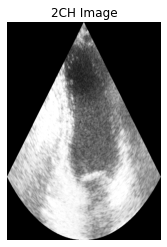

In [ ]:
# Example usage
image_index = 0  # Choose an index to view a specific image from the sequence
image_data = sequence_2CH_mhd[image_index]  # Replace 'sequence_2CH_mhd' with the desired image data
view_image(image_data, title="2CH Image")


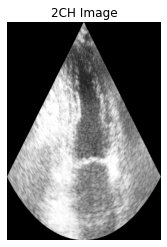

In [ ]:
# index 0 to 17 (18 frames)
image_index = 17  # Choose an index to view a specific image from the sequence
image_data = sequence_2CH_mhd[image_index]  # Replace 'sequence_2CH_mhd' with the desired image data
view_image(image_data, title="2CH Image")

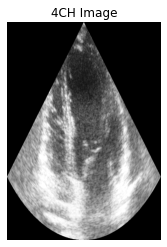

In [ ]:
image_index = 0  # Choose an index to view a specific image from the sequence
image_data = sequence_4CH_mhd[image_index]  # Replace 'sequence_2CH_mhd' with the desired image data
view_image(image_data, title="4CH Image")


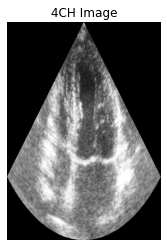

In [ ]:
# index 0 to 19 (20 frames)
image_index = 19  # Choose an index to view a specific image from the sequence
image_data = sequence_4CH_mhd[image_index]  # Replace 'sequence_2CH_mhd' with the desired image data
view_image(image_data, title="4CH Image")


find the contour points from the ground truth image

function takes the ground truth image and a threshold value as input, and returns the longest contour found in the image. The threshold value determines the level at which the contours are computed

In [ ]:
from skimage import measure

def get_initial_contour(ground_truth_image, threshold=0.5):
    # Find the contours using the threshold
    contours = measure.find_contours(ground_truth_image, threshold)

    # Choose the longest contour if there are multiple contours
    longest_contour = sorted(contours, key=lambda x: len(x), reverse=True)[0]

    # Return the contour as a numpy array
    return np.array(longest_contour)

Alternate implementation of get_initial_contour() function using edge detection and morphological operations

In [ ]:
import cv2

def get_initial_contour(ground_truth_image):
    # Apply edge detection using the Canny algorithm
    edges = cv2.Canny(np.uint8(ground_truth_image * 255), 100, 200)

    # Perform morphological dilation to connect any broken edges
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Find contours in the dilated_edges image
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Choose the longest contour if there are multiple contours
    longest_contour = sorted(contours, key=lambda x: len(x), reverse=True)[0]

    # Convert the contour to a numpy array
    contour_points = np.squeeze(longest_contour)

    return contour_points

function to apply the active contours algorithm on a single image:

In [ ]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour

def apply_active_contour(image, init_contour, alpha=0.01, beta=0.1, gamma=0.001, max_iter=2500):
    # Smooth the input image
    smoothed_image = gaussian(image, sigma=1)

    # Apply the active contour model
    snake = active_contour(
        smoothed_image,
        init_contour,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        max_iterations=max_iter,
        coordinates='rc'
    )

    return snake

Iterate through the dataset and apply active contours to each frame:
Initialize the contour using the provided ground truth (ED and ES frames).
Apply the active contour function to each frame in the sequence.

<ipython-input-80-1643888b4d0c>:9: FutureWarning: `max_iterations` is a deprecated argument name for `active_contour`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  snake = active_contour(


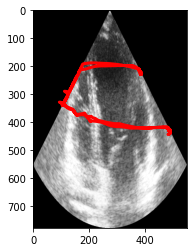

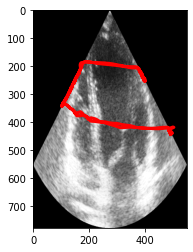

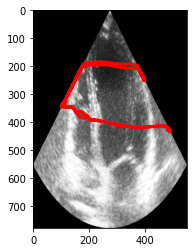

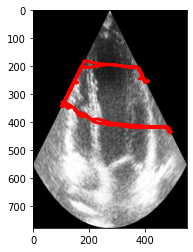

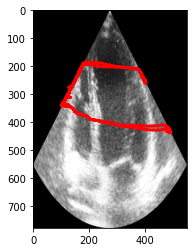

KeyboardInterrupt: ignored

In [ ]:
# Use the ground truth contour from the ED or ES frame as the initial contour
initial_contour = get_initial_contour(ED_gt_4CH_mhd[0])  # extract the contour from the ground truth image

# Apply active contour to all frames in the sequence
segmented_contours = []
for frame in sequence_4CH_mhd:  # Replace 'sequence_images' with actual sequence data
    snake = apply_active_contour(frame, initial_contour)
    segmented_contours.append(snake)

    # Visualize the segmentation
    plt.imshow(frame, cmap='gray')
    plt.plot(snake[:, 1], snake[:, 0], '-r', lw=3)
    plt.show()


In [89]:
patient_number = 1
ground_truth_ED_image = read_patient_mhd_file(patient_number, '2CH_ED_gt')[0]
sequence_images = read_patient_mhd_file(patient_number, '2CH_sequence')

<ipython-input-80-1643888b4d0c>:9: FutureWarning: `max_iterations` is a deprecated argument name for `active_contour`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  snake = active_contour(


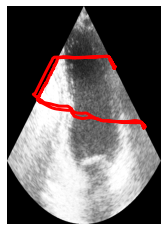

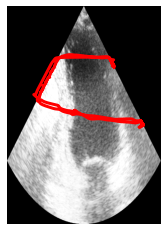

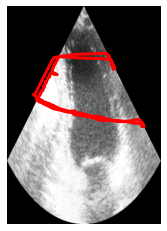

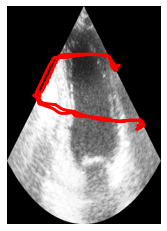

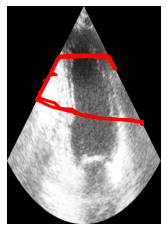

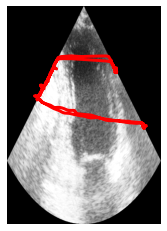

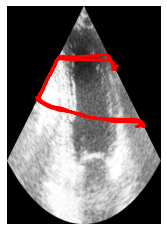

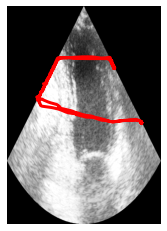

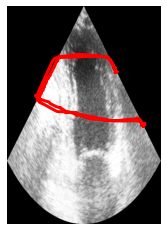

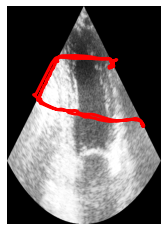

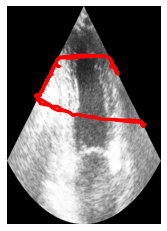

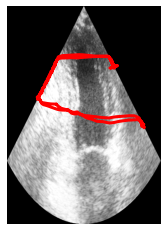

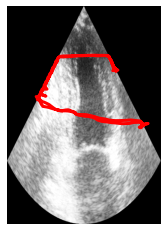

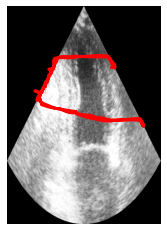

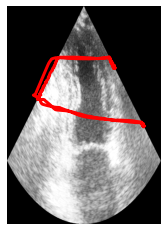

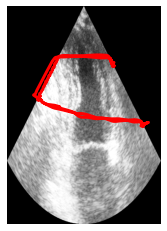

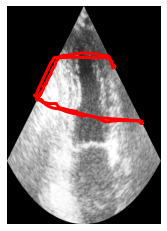

KeyboardInterrupt: ignored

In [90]:
# Use the ground truth contour from the ED frame as the initial contour
initial_contour = get_initial_contour(ground_truth_ED_image)

# Apply active contour to all frames in the sequence
segmented_contours = []
for frame in sequence_images:
    snake = apply_active_contour(frame, initial_contour)
    segmented_contours.append(snake)

    # Visualize the segmentation
    plt.imshow(frame, cmap='gray')
    plt.plot(snake[:, 1], snake[:, 0], '-r', lw=3)
    plt.axis('off')
    plt.show()